In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from tqdm import tqdm

In [2]:
dissemination_area_file = "data/statscan/census_2021/dissemination_areas/lda_000a21a_e/lda_000a21a_e.shp"
census_file = "data/statscan/census_2021/98-401-X2021006_Quebec_eng_CSV/98-401-X2021006_English_CSV_data_Quebec.csv"
census_encoding = "ISO-8859-1"

In [3]:
# Read dissemination area file
dissemination_areas = gpd.read_file(dissemination_area_file)
print(dissemination_areas.head())

      DAUID              DGUID  LANDAREA PRUID  \
0  10010232  2021S051210010232    0.0759    10   
1  10010233  2021S051210010233    0.1246    10   
2  10010234  2021S051210010234    0.1031    10   
3  10010235  2021S051210010235    0.0846    10   
4  10010236  2021S051210010236    0.1055    10   

                                            geometry  
0  POLYGON ((8979060.777 2152103.386, 8979061.674...  
1  POLYGON ((8978740.609 2151923.786, 8978723.483...  
2  POLYGON ((8979010.177 2152087.183, 8979035.303...  
3  POLYGON ((8978535.709 2151470.283, 8978455.289...  
4  POLYGON ((8978375.923 2151363.186, 8978285.711...  


In [4]:
# Read census file (~6 GB)
census = pd.read_csv(census_file, encoding=census_encoding)
print(census.head())

/var/folders/nz/8f1znby90q17dz1y25g4208h0000gn/T/ipykernel_4775/2996579066.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  census = pd.read_csv(census_file, encoding=census_encoding)


   CENSUS_YEAR           DGUID  ALT_GEO_CODE GEO_LEVEL GEO_NAME  TNR_SF  \
0         2021  2021A000011124             1   Country   Canada     3.1   
1         2021  2021A000011124             1   Country   Canada     3.1   
2         2021  2021A000011124             1   Country   Canada     3.1   
3         2021  2021A000011124             1   Country   Canada     3.1   
4         2021  2021A000011124             1   Country   Canada     3.1   

   TNR_LF  DATA_QUALITY_FLAG  CHARACTERISTIC_ID  \
0     4.3              20000                  1   
1     4.3              20000                  2   
2     4.3              20000                  3   
3     4.3              20000                  4   
4     4.3              20000                  5   

                             CHARACTERISTIC_NAME  ...  C2_COUNT_MEN+  \
0                               Population, 2021  ...            NaN   
1                               Population, 2016  ...            NaN   
2     Population percentag

In [5]:
dissemination_areas_dguids = dissemination_areas["DGUID"]
census_dguids = census["DGUID"]

In [ ]:
common_dguids = set(dissemination_areas_dguids) & set(census_dguids)
print(len(common_dguids))
print(list(common_dguids)[:5])

In [ ]:
census_qc = census[census["DGUID"].isin(common_dguids)]
dissemination_areas_qc = dissemination_areas[dissemination_areas["DGUID"].isin(common_dguids)]

print(f"census_qc: {len(census_qc)}/{len(census)} ({len(census_qc)/len(census)}%)")
print(f"dissemination_areas_qc: {len(dissemination_areas_qc)}/{len(dissemination_areas)} ({len(dissemination_areas_qc)/len(dissemination_areas)*100} %)")

# Part 1: Build a new census geospatial dataset for Quebec
Use dissemination areas as spatial unit.

In [8]:
def combine_hierarchical_rows(df, characteristics_of_interest, indent_column='CHARACTERISTIC_NAME'):
    # Create a copy of the dataframe
    df = df.copy()
    
    # Find indentation level for each row
    df['indent_level'] = df[indent_column].str.len() - df[indent_column].str.lstrip().str.len()
    
    result_rows = []
    
    for characteristic in characteristics_of_interest:
        # Find each occurrence of the characteristic
        char_indices = df[df[indent_column].str.strip() == characteristic].index
        
        for char_idx in char_indices:
            # Add the characteristic row itself
            current_row = df.loc[char_idx].copy()
            current_row['parent'] = None  # or '' if you prefer
            current_row['full_hierarchy'] = characteristic
            result_rows.append(current_row)
            
            # Get the base indentation level
            base_level = df.loc[char_idx, 'indent_level']
            hierarchy_stack = []
            
            # Get all rows that come after this characteristic
            subsequent_rows = df.loc[char_idx + 1:]
            
            # Keep rows until we hit another row with same or lower indentation
            for idx, row in subsequent_rows.iterrows():
                if row['indent_level'] <= base_level:
                    break
                
                # Update hierarchy stack based on indentation
                while hierarchy_stack and row['indent_level'] <= df.loc[hierarchy_stack[-1], 'indent_level']:
                    hierarchy_stack.pop()
                    
                # Add row to results with hierarchy information
                current_row = row.copy()
                current_row['parent'] = characteristic if not hierarchy_stack else df.loc[hierarchy_stack[-1], indent_column].strip()
                
                # Build full hierarchy path
                hierarchy_path = [characteristic] + [df.loc[i, indent_column].strip() for i in hierarchy_stack] + [row[indent_column].strip()]
                current_row['full_hierarchy'] = " > ".join(hierarchy_path)
                
                result_rows.append(current_row)
                hierarchy_stack.append(idx)
    
    # Create new dataframe from collected rows
    if result_rows:
        result_df = pd.DataFrame(result_rows)
        result_df = result_df.drop('indent_level', axis=1)
        return result_df
    else:
        return pd.DataFrame(columns=df.columns)

In [9]:
CHARACTERISTICS_OF_INTEREST = [
    "Total - Age groups of the population - 100% data",
    "Population, 2021",
    "Population, 2016",
    "Total private dwellings",
    "Private dwellings occupied by usual residents",
    "Land area in square kilometres",
    "Total - Household after-tax income groups in 2020 for private households - 100% data",
    "Total - Income statistics for private households - 100% data",
    "Unemployment rate",
]

In [ ]:
# Pre-process census data using groupby
census_grouped = census_qc.groupby('DGUID').apply(
    lambda x: combine_hierarchical_rows(x, CHARACTERISTICS_OF_INTEREST, indent_column="CHARACTERISTIC_NAME")
)

In [ ]:
census_grouped

In [ ]:
# Create a list to store all rows
all_rows = []

# Process each DGUID
for dguid in tqdm(common_dguids):
    census_at_dguid = census_grouped.loc[dguid]
    dissemination_area_at_dguid = dissemination_areas[dissemination_areas["DGUID"]==dguid]

    # Create the new row data
    new_row_data = {
        row["full_hierarchy"]: row["C1_COUNT_TOTAL"]
        for _, row in census_at_dguid.iterrows()
    }
    new_row_data["DGUID"] = dissemination_area_at_dguid["DGUID"].iloc[0]
    new_row_data["geometry"] = dissemination_area_at_dguid["geometry"].iloc[0]
    all_rows.append(new_row_data)

# Create final GeoDataFrame at once
combined_gdf = gpd.GeoDataFrame(all_rows)
combined_gdf.crs = dissemination_areas.crs
# combined_gdf["DGUID"] = combined_gdf["DGUID"].astype(str)

# Save files
combined_gdf.to_parquet(
    "data/output/census_2021_qc_parsed.parquet",
    compression="snappy",
    index=False,
    engine="pyarrow",
)

In [ ]:
combined_gdf

# Part 2: Combine with school data
Goal is to associate schools to StatsCan census regions. Ultimately, we want to be able to apply census data to determine socio-economic factors that apply to schools.

School district algo idea:
- Get school lat/lon
- Read stastcan census data in surroundinga area
- Grow outwards, accumulating students until school is full

TODO:
- [x] Merge full_addresses_avec_coor.csv with merged_clusttered_data.csv (join on Code) to get lat lon with "type" (prive ou public) and "Langue Enseignement"
- [x] Exclude rows with "type" == "prive" and "Langue Enseignement" == "Anglais"

In [ ]:
# Merge school names, ids and lat/lon into new csv
# Merge full_addresses_avec_coor.csv with merged_clusttered_data.csv (join on Code) to get lat lon with "Type" (prive ou public) and "Langue Enseignement"

a = pd.read_csv("data/school/merged_clustered_data.csv", index_col="Address")
b = pd.read_csv("data/school/full_addresses_avec_coor.csv", index_col="original_address")
schools = a.join(b, how="inner", lsuffix="_a", rsuffix="_b")
schools = schools.set_index("Code")
schools = schools[["School Name", "lat", "lon", "Full Address", "Code Postal", "Aggregate Dissemination Area Code", "Number of students", "Type", "Langue Enseignement"]]
schools.to_csv("data/output/schools_qc_basic.csv")

In [ ]:
print(len(a))
print(len(b))
print(len(schools))
print(schools["Type"].value_counts())
print(schools["Langue Enseignement"].value_counts())
schools

In [8]:
# Now build spatial relationship between schools and stascan dissemination areas polygons

# Read files
schools = pd.read_csv("data/output/schools_qc_basic.csv")
diss_areas = gpd.read_parquet("data/output/census_2021_qc_parsed.parquet")
combined_gdf = gpd.read_parquet("data/output/census_2021_qc_parsed.parquet")
schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=[Point(lon, lat) for lon, lat in zip(schools['lon'], schools['lat'])],
    crs="EPSG:4326"  # Assuming input coordinates are in WGS84
)

# Keep schools that are not english and are public
schools_fr_public_gdf = schools_gdf[(~schools_gdf["Langue Enseignement"].str.contains("EN", na=False)) & (schools_gdf["Type"] == "Public")]
print(f"Number of schools: {len(schools_gdf)}")
print(f"Number of non-english, public schools: {len(schools_fr_public_gdf)}")

# Reproject both datasets UTM
utm_crs = schools_gdf.estimate_utm_crs()
schools_fr_public_gdf = schools_fr_public_gdf.to_crs(utm_crs)
diss_areas_gdf = diss_areas.to_crs(utm_crs)
combined_gdf = combined_gdf.to_crs(utm_crs)

# Match
diss_areas_gdf = gpd.sjoin_nearest(diss_areas_gdf, schools_fr_public_gdf[['Code', 'geometry']], distance_col="distance")
diss_areas_gdf.drop(columns=['index_right'], inplace=True)

# Save full datasets
diss_areas_gdf.to_parquet("data/output/census_2021_qc_parsed_with_schools_fr_public.parquet", compression="snappy", index=False, engine="pyarrow")
diss_areas_gdf.to_csv("data/output/census_2021_qc_parsed_with_schools_fr_public.csv")
# Save simple mapping only
diss_areas_gdf[["DGUID", "Code", "distance"]].to_csv("data/output/census_2021_qc_parsed_with_schools_fr_public_mapping.csv")

diss_areas_gdf.head()

Number of schools: 465
Number of non-english, public schools: 278


AttributeError: 'NoneType' object has no attribute 'copy'

,Total - Age groups of the population - 100% data,Total - Age groups of the population - 100% data > 0 to 14 years,Total - Age groups of the population - 100% data > 0 to 14 years > 0 to 4 years,Total - Age groups of the population - 100% data > 0 to 14 years > 5 to 9 years,Total - Age groups of the population - 100% data > 0 to 14 years > 10 to 14 years,Total - Age groups of the population - 100% data > 15 to 64 years,Total - Age groups of the population - 100% data > 15 to 64 years > 15 to 19 years,Total - Age groups of the population - 100% data > 15 to 64 years > 20 to 24 years,Total - Age groups of the population - 100% data > 15 to 64 years > 25 to 29 years,Total - Age groups of the population - 100% data > 15 to 64 years > 30 to 34 years,...,Total - Income statistics for private households - 100% data > Median after-tax income of household in 2020 ($) > Total - Income statistics for one-person private households - 100% data > Median total income of one-person households in 2020 ($),Total - Income statistics for private households - 100% data > Median after-tax income of household in 2020 ($) > Total - Income statistics for one-person private households - 100% data > Median after-tax income of one-person households in 2020 ($),Total - Income statistics for private households - 100% data > Median after-tax income of household in 2020 ($) > Total - Income statistics for two-or-more-persons private households - 100% data,Total - Income statistics for private households - 100% data > Median after-tax income of household in 2020 ($) > Total - Income statistics for two-or-more-persons private households - 100% data > Median total income of two-or-more-person households in 2020 ($),Total - Income statistics for private households - 100% data > Median after-tax income of household in 2020 ($) > Total - Income statistics for two-or-more-persons private households - 100% data > Median after-tax income of two-or-more-person households in 2020 ($),Unemployment rate,DGUID,geometry,Code,distance
0,750.0,140.0,30.0,55.0,55.0,500.0,45.0,30.0,50.0,40.0,...,47600.0,40000.0,225.0,124000.0,105000.0,8.0,2021S051224580458,"POLYGON ((158526.953 5045587.965, 158818.043 5...",864275,172.817175
1,415.0,65.0,25.0,25.0,20.0,290.0,20.0,20.0,40.0,45.0,...,40400.0,37600.0,120.0,77500.0,68500.0,22.2,2021S051224663237,"POLYGON ((148182.697 5060326.606, 148169.289 5...",762252,1389.535745
2,1930.0,375.0,105.0,140.0,125.0,1235.0,125.0,105.0,115.0,90.0,...,49600.0,41600.0,545.0,90000.0,78000.0,10.5,2021S051224663036,"POLYGON ((121022.250 5048077.895, 120920.908 5...",763236,2925.658921
3,440.0,85.0,25.0,30.0,30.0,235.0,15.0,15.0,25.0,40.0,...,40400.0,35200.0,135.0,78500.0,70500.0,6.5,2021S051224470168,"POLYGON ((207085.471 5032519.916, 206957.081 5...",866052,646.131672
4,730.0,150.0,25.0,55.0,65.0,535.0,65.0,60.0,35.0,25.0,...,48400.0,40400.0,195.0,120000.0,102000.0,11.7,2021S051224650624,"POLYGON ((126096.271 5052436.211, 126022.504 5...",831150,1152.803547


<Axes: >

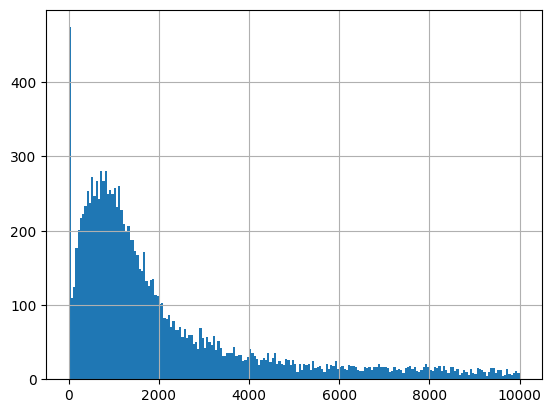

In [17]:
diss_areas_gdf["distance"].hist(bins=200, range=(0, 10000))

In [27]:
def percentage_under_distance(df, distance_value):
    total_points = len(df)
    points_under_distance = len(df[df['distance'] <= distance_value])
    percentage = (points_under_distance / total_points) * 100
    return percentage

# Example usage
distance_value = 2000  # specify the distance value
percentage = percentage_under_distance(diss_areas_gdf, distance_value)
print(f"Percentage of data points under {distance_value} meters: {percentage:.2f}%")

Percentage of data points under 2000 meters: 60.75%
